In [1]:
using Pkg
using GeometricIntegrators
using Plots
# Pkg.add("AbstractNeuralNetworks")
using AbstractNeuralNetworks
Pkg.status("GeometricIntegrators")

Status `~/.julia/environments/v1.9/Project.toml`
⌃ [dcce2d33] GeometricIntegrators v0.12.1
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using IJulia
installkernel("Julia (10 threads)", env = Dict("JULIA_NUM_THREADS" => "10"))
Threads.nthreads()

[ Info: Installing Julia (10 threads) kernelspec in /home/gui09301998/.local/share/jupyter/kernels/julia-_10-threads_-1.9


10

### Integrator

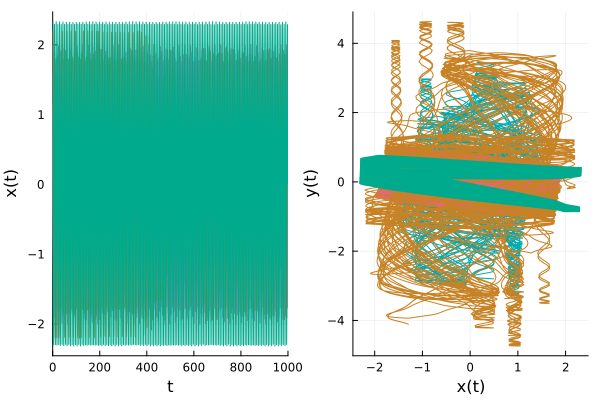

In [3]:
# params = (m1 = [2,3], m2 = [2,3], k1 = [0.1,0.2], k2 =  [0.1,0.2], k =  [0.1,0.2])
params = (m1 = 1, m2 = 2, k1 = 0.1, k2 = 0.1, k = 0.2)

t_integration = 1000

function q̇(v, t, q, p, params)
    v[1] = p[1]/params.m1
    v[2] = p[2]/params.m2
end

function ṗ(f, t, q, p, params)
    f[1] = -params.k1 * q[1] - params.k * (cos(10*q[1]) + 1) * (q[1] - q[2]) + params.k /2 * (q[1] - q[2])^2 * 10 * sin(10 * q[1])
    f[2] = -params.k2 * q[2] + params.k * (cos(10*q[1]) + 1) * (q[1] - q[2]) 
end


p1 = plot(xlims=[0,t_integration], xlab="t", ylab="x(t)", legend=:none)
p2 = plot( xlab="x(t)", ylab="y(t)", legend=:none)

x = Vector{Vector}()
x = []

for x0 in LinRange(0.1, 2, 3) 
    for x1 in LinRange(0.1, 2, 3) 
        params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
        pode = PODEProblem( q̇, ṗ, (0.0, t_integration), 0.1, [x0,0.4], [x1, 0.]; parameters = params)
        sol = integrate(pode,ImplicitMidpoint())
        # Add for input and output
        push!(x, [sol.q[:,1], sol.q[:,2], sol.p[:,1], sol.p[:,2]])
        plot!(p1,sol.t, sol.q[:,1])
        plot!(p2, sol.q[:,1], sol.q[:,2])
    end
end

n_params = 9
plot(p1, p2, layout = 2)



In [4]:
using KernelAbstractions
size(x[1][1])

@kernel function to_matrix!(matrix, x)
    i,j,k = @index(Global, NTuple)
    matrix[i,j,k] = x[i][j][k]
end
x_matrix = zeros(n_params, 4,t_integration)
kernel! = to_matrix!(CPU())
kernel!(x_matrix, x, ndrange = size(x_matrix))
x_matrix = Float32.(x_matrix)

9×4×1000 Array{Float32, 3}:
[:, :, 1] =
 0.10503   0.399674   0.101212   -0.0130308
 0.152384  0.399722   1.04534    -0.0111358
 0.199728  0.399766   1.98912    -0.00935971
 1.04996   0.40007   -0.10147     0.00281501
 1.09713   0.40015    0.835123    0.00600707
 1.14433   0.40024    1.77324     0.00960629
 2.00225   0.401019  -0.0098573   0.0407408
 2.05046   0.400848   0.968566    0.0339266
 2.09833   0.400666   1.93317     0.0266243

[:, :, 2] =
 0.11009   0.398708   0.101165  -0.025627
 0.204189  0.398978   1.02687   -0.01862
 0.2983    0.399183   1.95375   -0.0139707
 1.03993   0.400266  -0.299937   0.00501127
 1.13303   0.400763   0.600904   0.0185044
 1.22685   0.40131    1.52764    0.0331938
 1.99898   0.404076  -0.120983   0.081539
 2.09718   0.403019   0.900024   0.0528945
 2.19076   0.402023   1.76414    0.0276742

[:, :, 3] =
 0.115113  0.397123   0.0997847  -0.0377677
 0.254754  0.397919   0.995728   -0.0237457
 0.394687  0.398383   1.90175    -0.0180128
 1.02019   0.40053

In [15]:
# using Base
# input = []
# output = []
# for i in 1:size(tensor)[1]
#     for j in 1:size(tensor)[3]-1
#         push!(input, tensor[i,:,j])
#         push!(output, tensor[i,:,j+1])
#     end
# end

const batch_size = 10
time_steps = Int.(floor.(rand(batch_size)*1000))
params = Int(ceil(rand()*n_params))
@kernel function get_batch!(batch_matrix, input, params, time_steps)
    i,j = @index(Global, NTuple)
    batch_matrix[i,j] = input[params,i,time_steps[j]]
end
input_matrix = zeros(4,batch_size)
output_matrix = zeros(4,batch_size)
kernel! = get_batch!(CPU())
kernel!(input_matrix, x_matrix,params, time_steps, ndrange = size(input_matrix))
kernel!(output_matrix, x_matrix,params, time_steps .+ 1, ndrange = size(input_matrix))

In [6]:
@kernel function get_all_dataset!(ds_input_matrix, input, param)
    i,j = @index(Global, NTuple)
    ds_input_matrix[i,j] = input[j÷1001+1][i][j÷n_params + param]
end
ds_input_matrix = zeros(4, (n_params-1)*(1001)) 
ds_output_matrix = zeros(4, (n_params-1)*(1001)) 
kernel! = get_all_dataset!(CPU())
kernel!(ds_input_matrix, x, 0, ndrange = size(ds_input_matrix))
kernel!(ds_output_matrix, x, 1, ndrange = size(ds_output_matrix))

In [7]:
ds_output_matrix

4×8008 Matrix{Float64}:
  0.10503     0.10503     0.10503    …  -1.05036   -1.05036   -1.99936
  0.399674    0.399674    0.399674      -0.99754   -0.99754    0.0439717
  0.101212    0.101212    0.101212       3.32156    3.32156   -1.73764
 -0.0130308  -0.0130308  -0.0130308     -0.224279  -0.224279  -0.310721

In [8]:

Pkg.activate("./GeometricMachineLearning.jl")
using GeometricMachineLearning

  Activating project at `/mnt/c/Users/guill/workspace/CEMRACS/Cemracs2023/Guillaume/GeometricMachineLearning.jl`
[ Info: Precompiling GeometricMachineLearning [194d25b2-d3f5-49f0-af24-c124f4aa80cc]


In [19]:
using CUDA
CUDA.device()
input_matrix[:,1]
ds_output_matrix

4×8008 Matrix{Float64}:
  0.10503     0.10503     0.10503    …  -1.05036   -1.05036   -1.99936
  0.399674    0.399674    0.399674      -0.99754   -0.99754    0.0439717
  0.101212    0.101212    0.101212       3.32156    3.32156   -1.73764
 -0.0130308  -0.0130308  -0.0130308     -0.224279  -0.224279  -0.310721

### ResNet

In [22]:
using GeometricMachineLearning: ResNet
using Random
using LinearAlgebra
using Zygote
using ProgressMeter
using AbstractNeuralNetworks

model = Chain(ResNet(4, tanh), 
            ResNet(4)
)
ps = initialparameters(CPU(),Float32, model)
model(input_matrix[:,1], ps)
# apply(model,input_matrix[:,1] |> cu, ps, st)[1]

n_time_steps = t_integration 
const batch_size = 100
n_epochs = 2000
opt = Optimizer(AdamOptimizer(), ps)

function loss(ps, x, y)
    norm(model(x, ps) - y)/size(x,2)^(0.5) 
end
println(loss(ps, ds_input_matrix  , ds_output_matrix))

input_matrix = zeros(4,batch_size)
output_matrix = zeros(4,batch_size)

@showprogress "training network" for _ in 1:(n_time_steps ÷ batch_size*n_epochs)
    time_steps = Int.(floor.(rand(batch_size) * (n_time_steps - 1) .+ 1))
    params = Int(ceil(rand()*n_params ))
    input_matrix = x_matrix[params, :, time_steps]
    output_matrix = x_matrix[params, :, time_steps .+ 1]
    # kernel! = get_batch!(CUDABackend())
    # kernel!(input_matrix, x,params, time_steps |> cu, ndrange = size(input_matrix))
    # kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))
    grad = Zygote.gradient(p -> loss(p, input_matrix, output_matrix ), ps)[1]
    optimization_step!(opt, model, ps, grad)
    # println(loss(ps, ds_input_matrix, ds_output_matrix))
end
println(loss(ps, ds_input_matrix  , ds_output_matrix))

1.7840299738195207


training network 100%|███████████████████████████████████| Time: 0:00:01


0.12814607762036329


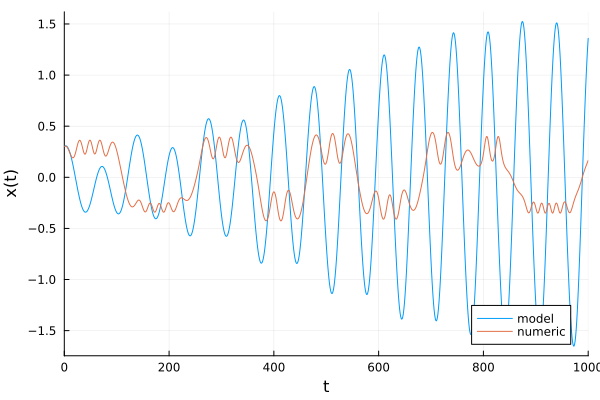

In [25]:
n_int = 1000
xt = [0.3,0.4,0.1,0.]
X = (q1 = [], q2 = [], p1 = [], p2 = [])
for t in 1:n_int
    xt = model(xt, ps)
    push!(X.q1, xt[1])
    push!(X.q2, xt[2])
    push!(X.p1, xt[3])
    push!(X.p2, xt[4])
end
params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
pode = PODEProblem(q̇, ṗ, (0.0, n_int), 0.1, [0.3,0.5], [0.1, 0.9]; parameters = params)
sol = integrate(pode,ImplicitMidpoint())
p1 = plot(xlims=[0,n_int], xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p1,X.q1, label="model")
plot!(p1,sol.q[:,1], label="numeric")

# p1 = plot( xlab="t", ylab="x(t)", legend=:bottomright)
# plot!(p1,sol.q[:,1], sol.q[:,2], label="numeric")
# plot!(p1,X.q1, X.q2, label="model")



### SympNet

In [26]:
using GPUArrays
@inline function (d::Gradient{true,true})(x::AbstractGPUVecOrMat, ps::NamedTuple, st::NamedTuple)
    size(x)[1] == d.dim || error("Dimension mismatch.")
    N = d.dim÷2
    q, p = assign_q_and_p(x, N)
    return vcat(q + ps.weight' *
            (ps.scale .* d.activation.(ps.weight * p .+ vec(ps.bias))),
                    p), st
end

@inline function(d::Gradient{true,false})(x::AbstractGPUVecOrMat, ps::NamedTuple, st::NamedTuple)
        size(x)[1] == d.dim || error("Dimension mismatch.")
        N = d.dim÷2
        q, p = assign_q_and_p(x, N)
        return vcat(q, p + ps.weight' *
                        (ps.scale .* d.activation(ps.weight*q .+ vec(ps.bias)))), st
end

function assign_first_half!(q, x)
        i = CUDA.threadIdx().x
        q[i] = x[i]
        return
end
function assign_second_half!(p, x, N)
        i = CUDA.threadIdx().x
        p[i] = x[i+N]
        return
end
function assign_q_and_p(x, N)
        q = CUDA.zeros(eltype(x), N)
        p = CUDA.zeros(eltype(x), N)
        CUDA.@cuda threads=N assign_first_half!(q, x)
        CUDA.@cuda threads=N assign_second_half!(p, x, N)
        q, p
end

assign_q_and_p (generic function with 1 method)

In [30]:
input_matrix[:,1]

4-element Vector{Float32}:
  1.2708976
 -0.84135
 -2.1630902
  0.42302817

In [46]:
model_symp = Chain(Gradient(4,100, tanh; change_q=true),
            Gradient(4,100, tanh; change_q=false),
            Gradient(4,100, tanh; change_q=true),
            Gradient(4,100; change_q=false)
)

ps = initialparameters(CPU(),Float32, model_symp)
model_symp(input_matrix[:,1], ps)

n_time_steps = t_integration
const batch_size = 100
n_epochs = 200
opt = Optimizer(AdamOptimizer(0.001), ps)

function loss(ps, x, y)
    norm(model_symp(x, ps) - y)/size(x,2)^(0.5) 
end
println(loss(ps, ds_input_matrix[:,3], ds_output_matrix[:,3]))

function ds_loss(ps, x, y)
    sum([loss(ps, x[:,i], y[:,i]) for i in 1:size(x)[2]]) / size(x)[2]
end
println(loss(ps,ds_input_matrix, ds_output_matrix ))

input_matrix = zeros(4,batch_size)
output_matrix = zeros(4,batch_size)

@showprogress "training sympnet" for _ in 1:(n_time_steps ÷ batch_size*n_epochs)
    idx = Int.(floor.(1 * (size(ds_input_matrix)[2] -1)) +1)
    time_steps = Int.(floor.(rand(batch_size) * (n_time_steps - 1) .+ 1))
    params = Int(ceil(rand()*n_params ))
    input_matrix = x_matrix[params, :, time_steps]
    output_matrix = x_matrix[params, :, time_steps .+ 1]
    # kernel! = get_batch!(CPU())
    # kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
    # kernel!(output_matrix, x,params, time_steps .+ 1, ndrange = size(input_matrix))
    grad = Zygote.gradient(p -> loss(p, input_matrix, output_matrix), ps)[1]
    optimization_step!(opt, model_symp, ps, grad)
    # println(loss(ps, ds_input_matrix, ds_output_matrix))
end
println(ds_loss(ps,ds_input_matrix, ds_output_matrix ))

0.04809473867733496
0.31410171678267457


training sympnet 100%|███████████████████████████████████| Time: 0:00:05


0.07279283367693609


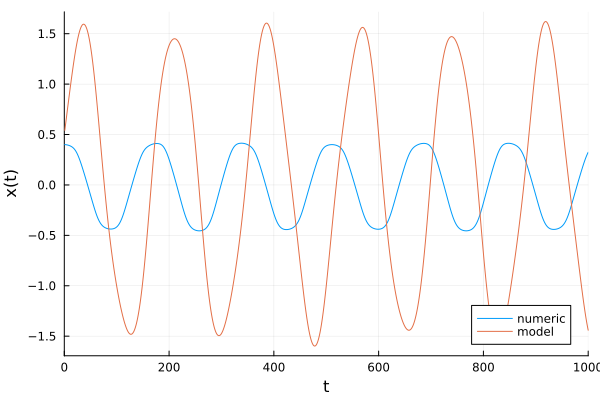

In [53]:
n_int = 1000
xt = [0.3,0.5,0.9,0.9]
X = (q1 = [], q2 = [], p1 = [], p2 = [])
for t in 1:n_int
    xt = model_symp(xt, ps)
    push!(X.q1, xt[1])
    push!(X.q2, xt[2])
    push!(X.p1, xt[3])
    push!(X.p2, xt[4])
end
params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
pode = PODEProblem(q̇, ṗ, (0.0, n_int), 0.1, [0.3,0.4], [0.1, 0.]; parameters = params)
sol = integrate(pode,ImplicitMidpoint())
p1 = plot( xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p1,sol.q[:,1], sol.q[:,2], label="numeric")
plot!(p1,X.q1, X.q2, label="model")

p2 = plot(xlims=[0,n_int], xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p2,sol.q[:,1], label="numeric")
plot!(p2,X.q1, label="model")

### Transformer

In [54]:
const n_rolled_steps = 8
const batch_size = 10

time_steps = [Int.(floor.(rand(batch_size)*1000)) for _ in 1:batch_size]
[time_steps[i] .+ 1 for i in 1:batch_size]
params = Int(ceil(rand()*n_params))


@kernel function get_batch_transformer!(batch_matrix, input, params, time_steps)
    i,j,k = @index(Global, NTuple)
    batch_matrix[i,j,k] = input[params][i][time_steps[k][j]]
end
input_matrix = zeros(4,n_rolled_steps, batch_size)
output_matrix = zeros(4,n_rolled_steps, batch_size)
kernel! = get_batch_transformer!(CPU())
kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
kernel!(output_matrix, x,params, [time_steps[i] .+ 1 for i in 1:batch_size], ndrange = size(input_matrix))


In [64]:
model_transformer = Chain(Transformer(4, 4,3, Stiefel=false)
)

ps = initialparameters(CPU(),Float32, model_transformer)
model_transformer(input_matrix[:,:,1], ps)

n_time_steps = length(x[1][1])
const n_rolled_steps = 8
const batch_size = 10
n_epochs = 50
opt = Optimizer(AdamOptimizer(), ps)

function loss(ps, x, y)
    norm(Lux.apply(model_transformer,x,ps,st)[1][:,n_rolled_steps,:] - y[:,n_rolled_steps,:])/size(x,2)^(0.5) 
end
println(loss(ps, input_matrix, output_matrix))

# function ds_loss(ps, x)
#     loss_sum = 0
#     for j in 1:n_params
#         for t in 0:size(x[1][1])[1] - batch_size - 2
#             input_matrix = zeros(4,batch_size)
#             output_matrix = zeros(4,batch_size)
#             time_steps = [i + t for i in 1:batch_size]
#             kernel! = get_batch!(CPU())
#             kernel!(input_matrix, x, j, time_steps, ndrange = size(input_matrix))
#             kernel!(output_matrix, x,j, time_steps .+ 1, ndrange = size(output_matrix))
#             loss_sum = loss_sum + loss(ps, input_matrix, output_matrix)
#         end
#     end
#     return loss_sum / (size(x[1][1])[1] * n_params)
# end
# println(ds_loss(ps, x ))

# @showprogress "training Transformer" for _ in 1:(n_time_steps ÷ batch_size^2 *n_epochs)
#     input_matrix = zeros(4,n_rolled_steps,batch_size)
#     output_matrix = zeros(4,n_rolled_steps,batch_size)
#     time_steps = []
#     for i in 1:batch_size
#         idx = Int.(floor.(rand() * (n_time_steps - batch_size - 1) ))
#         time_step = [i + idx for i in 1:batch_size]
#         push!(time_steps, time_step)
#     end
#     params = Int(ceil(rand()*n_params))
#     kernel! = get_batch_transformer!(CPU())
#     kernel!(input_matrix, x,params, time_steps, ndrange = size(input_matrix))
#     kernel!(output_matrix, x,params, [time_steps[i] .+ 1 for i in 1:batch_size], ndrange = size(input_matrix))
#     grad = Zygote.gradient(p -> loss(p, Array{Float32,3}(input_matrix), Array{Float32,3}(output_matrix)), ps)[1]
#     optimization_step!(opt, model_transformer, ps, grad)
# end
# println(ds_loss(ps, x ))

LoadError: UndefVarError: `Lux` not defined

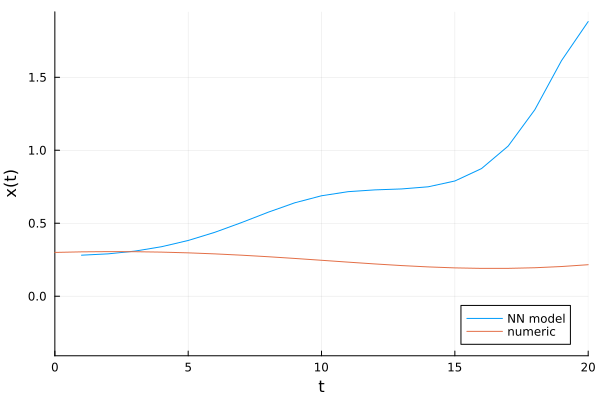

In [42]:
# Constructing 8 time steps to be unrolled for the transformer
n_int = 20
xt = [0.3,0.5,0.1,0.9]
params = (m1 = 2, m2 = 2, k1 = 1.5, k2 = 0.1, k = 0.2)
pode = PODEProblem(q̇, ṗ, (0.0, 0.8), 0.1, [0.3,0.5], [0.1, 0.9]; parameters = params)
sol = integrate(pode,ImplicitMidpoint())
x_transformer = []
push!(x_transformer, [sol.q[:,1], sol.q[:,2], sol.p[:,1], sol.p[:,2]])

input_matrix = zeros(4,8)
output_matrix = zeros(4,8)
time_steps = [i for i in 0:8]
kernel! = get_batch!(CPU())
kernel!(input_matrix, x_transformer, 1, time_steps, ndrange = size(input_matrix))
kernel!(output_matrix, x_transformer, 1, time_steps .+ 1, ndrange = size(output_matrix))

# Actual integration for the NN model and the numeric model
xt = input_matrix[:,8]
X = (q1 = [], q2 = [], p1 = [], p2 = [])
for t in 1:n_int
    output_matrix = Lux.apply(model_transformer,input_matrix,ps,st)[1]
    push!(X.q1, input_matrix[:,8][1])
    push!(X.q2, input_matrix[:,8][2])
    push!(X.p1, input_matrix[:,8][3])
    push!(X.p2, input_matrix[:,8][4])
    input_matrix = hcat(input_matrix[:,2:8] ,output_matrix[:,8])
end
pode = PODEProblem(q̇, ṗ, (0.0, n_int), 0.1, [0.3,0.5], [0.1, 0.9]; parameters = params)
sol = integrate(pode,ImplicitMidpoint())
p1 = plot(xlims=[0,n_int], xlab="t", ylab="x(t)", legend=:bottomright)
plot!(p1,X.q1, label="NN model")
plot!(p1,sol.q[:,1], label="numeric")

In [62]:
input_matrix

4×8×10 Array{Float64, 3}:
[:, :, 1] =
  0.037997   -0.0523796     0.134243   …  0.142912    0.0353     0.135061
  0.222202   -0.000175517   0.313124      0.359811    0.146852   0.397838
 -0.0267192  -0.142092     -0.0971009     0.0757734  -0.191655   0.0849753
 -0.293856   -0.311451     -0.169267      0.114305   -0.270226  -0.0139557

[:, :, 2] =
 0.039975   0.00567647  -0.113455   …  -0.142917   -0.0692024   0.0939081
 0.250354  -0.0283988   -0.386201      -0.327222   -0.399743    0.374693
 0.03762    0.206756     0.0965677      0.0171745  -0.0562458  -0.109024
 0.273298   0.289005    -0.0857492     -0.170181   -0.0247488  -0.104236

[:, :, 3] =
  0.035551   -0.101819    0.128028   …   0.101676   -0.0132216  -0.0717367
  0.191934   -0.385791    0.397026       0.139274   -0.161917   -0.202202
 -0.0224718  -0.0961877   0.0923063     -0.0750132  -0.0627875  -0.0157254
 -0.311178    0.0902653  -0.0315425     -0.29338    -0.31643     0.302737

[:, :, 4] =
 0.0301236  -0.11469    -0.0949976